# Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
!pip install augmentor

In [2]:
# Importing the necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.models import Sequential
import Augmentor
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
## Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r"/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train")
data_dir_test = pathlib.Path(r"/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Test")

In [5]:
# Count the number of images for each directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Defining parameters for our loader:

- As per the problem statement, we are setting the image size as 180x180
- Setting batch size as 32

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123 # Setting seed with a random number to ensure reproducibility

Use 80% of the images for training, and 20% for validation.

In [7]:
## Creating the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of data used for validation
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),  # Resizing images
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
## Creating the Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,  # Same split as above
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
# Our directory contains separate folder for each classes, so we are extracting the class names here
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Let's create a code to visualize one instance of all the nine classes present in the dataset

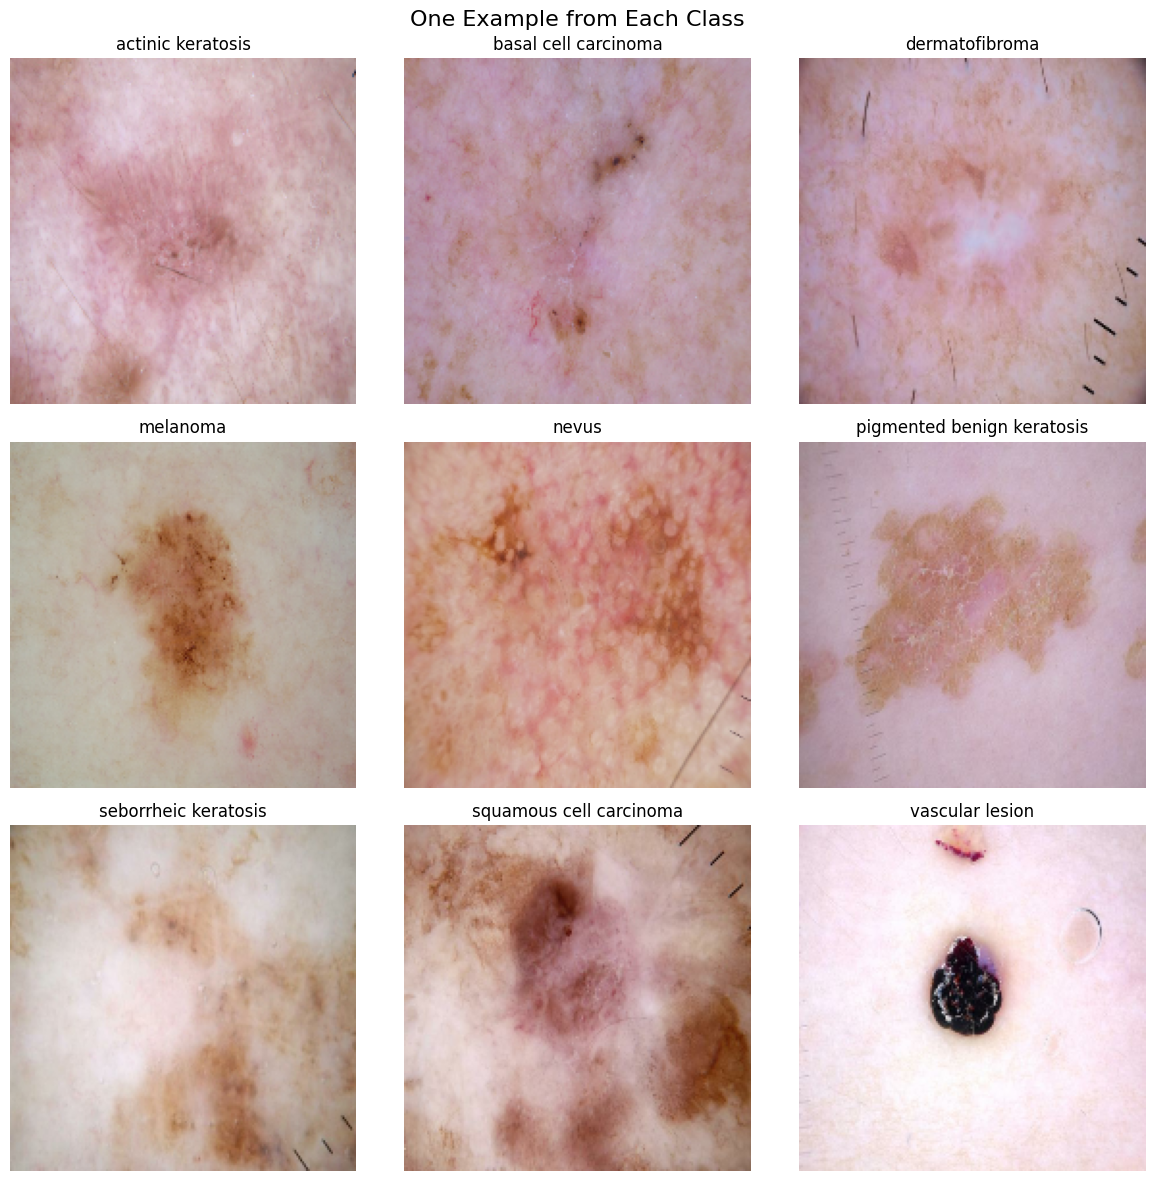

In [10]:
# Mapping class names
class_names = train_ds.class_names  # Extract class names from the dataset

# Initializing a dictionary to store one example per class
example_images = {class_name: None for class_name in class_names}

# Iterate over the dataset to collect one image per class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]  # Converting label to class name
        if example_images[class_name] is None:  # Check if no image is stored for this class
            example_images[class_name] = img.numpy()
        # Stop if all classes have at least one image
        if all(img is not None for img in example_images.values()):
            break
    if all(img is not None for img in example_images.values()):
        break

# Plot the examples
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names):
    plt.subplot(3, 3, i + 1)  # 3x3 grid for 9 classes
    plt.imshow(example_images[class_name] / 255.0)  # Normalize pixel values for display
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("One Example from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Our objective is to create a CNN model, which can accurately detect 9 classes present in the dataset.

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Checking the shapes
for images, labels in train_ds.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (32, 180, 180, 3)
Labels shape: (32,)


In [13]:
# Creating an initial CNN model using 2 Convolution layer with 2x2 pooling. This is our first base model.
model1 = keras.Sequential([
    # Input preprocessing: normalize pixel values to [0, 1]
    layers.InputLayer(shape=(180,180,3)),
    layers.Rescaling(1.0 / 255), # Using layers.Rescaling instead of layers.experimental.preprocessing.Rescaling because it is not available in recent versions of Tensorflow

    # # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # # Flatten layer to convert 3D data to 1D
    layers.Flatten(),

    # # Fully connected (dense) layer
    layers.Dense(128, activation='relu'),

    # # Output layer
    layers.Dense(9, activation='softmax')
    ])

### Compile the model
For our model, we are using 'adam' optimizer and sparse_categorical_entropy as loss function.

In [14]:
model1.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# View the summary of all layers
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20 #As per the requirement
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.2535 - loss: 2.8479 - val_accuracy: 0.3478 - val_loss: 2.4465
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4510 - loss: 1.4514 - val_accuracy: 0.2609 - val_loss: 2.7377
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5881 - loss: 1.1349 - val_accuracy: 0.1304 - val_loss: 3.3880
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6734 - loss: 0.9041 - val_accuracy: 0.2609 - val_loss: 3.8771
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7692 - loss: 0.6596 - val_accuracy: 0.2609 - val_loss: 4.0536
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8104 - loss: 0.5751 - val_accuracy: 0.2609 - val_loss: 4.2524
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8559 - loss: 0.4113 - val_accuracy: 0.2174 - val_loss: 5.0718
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8985 - loss: 0.3128 - val_acc

### Visualizing training results

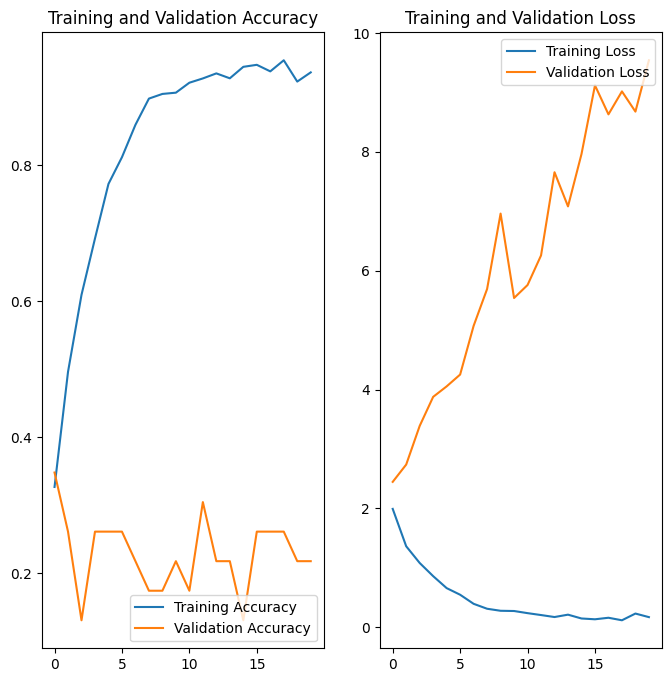

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
true_labels = np.concatenate([y for x, y in val_ds], axis=0)  # Extract true labels from validation dataset
val_predictions = model1.predict(val_ds)  # Predict on the validation dataset
predicted_classes = np.argmax(val_predictions, axis=1)
predicted_classes

# Create confusion matrix
report = classification_report(true_labels, predicted_classes)  # Create classification report
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.40      0.67      0.50         3
           5       0.33      0.50      0.40         4
           6       0.00      0.00      0.00         3
           7       1.00      0.17      0.29         6

    accuracy                           0.22        23
   macro avg       0.25      0.19      0.17        23
weighted avg       0.37      0.22      0.21        23



### Observations:

- The training accuracy of the model increases while its validation accuracy is very low (only 22%) and inconsistent in shape.
- The loss function for the training data reduces but loss function for validation data significantly increases.
- Validation loss is very high and requires improvement.

The evidences prove that the model is performing very well with the training data but poorly with the validation data. Hence . the model is overfitting.

**Model Tuning** : To handle the overfitting, we will use the data augmentation strategy here which will force the model to learn features that are invariant to certain transformations by randomly flipping the image horizontally thereby generating a new variant.

In [19]:
# Creating data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                      img_width,
                      3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Let us check how the augmentation strategy works for one instance of training image

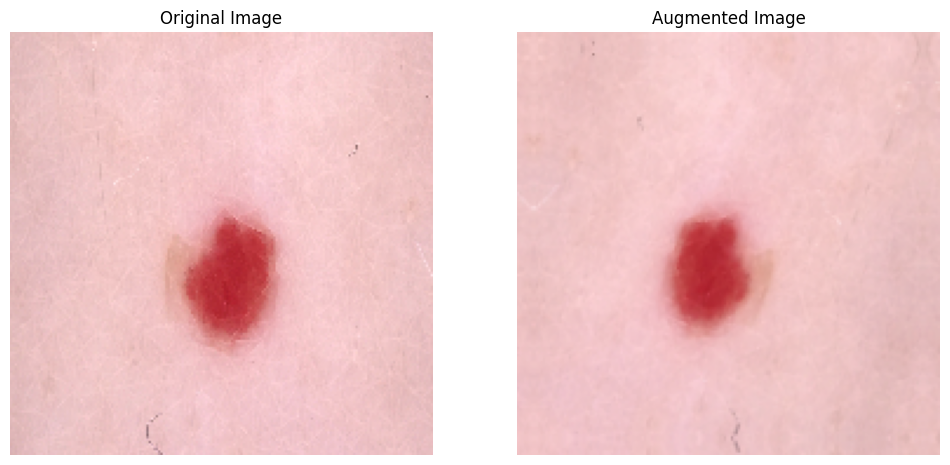

In [20]:
# Path to Train directory
class_path = os.path.join(data_dir_train, class_name)
image_files = os.listdir(class_path)

# Load the first image from the selected class
image_path = os.path.join(class_path, image_files[0])
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Apply the augmentation
augmented_image = data_augmentation(img_array)

# Convert the augmented image back to a format that can be plotted
augmented_image = augmented_image[0].numpy().astype("uint8")

# Plot the original and augmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(augmented_image)
axes[1].set_title("Augmented Image")
axes[1].axis('off')

plt.show()


As we can see, the image has been flipped creating new learing opportunities for our model

### Create the Augmented model, compile and train the model


In [21]:
# Creating the model - with augmentation
model2 = keras.Sequential([
    data_augmentation,

     # # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Dropout layer to reduce overfitting

    # # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Dropout layer to reduce overfitting

    # # Flatten layer to convert 3D data to 1D
    layers.Flatten(),

    # # Fully connected (dense) layer
    layers.Dense(128, activation='relu'),

    # # Output layer
    layers.Dense(9, activation='softmax')
    ])



### Compiling the model

In [22]:
model2.compile(
    optimizer='adam',  # Adam optimizer
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metrics to track during training
)

In [23]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,167,689 (57.86 MB)

 Trainable params: 15,167,689 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [24]:
history = model2.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=20,
    batch_size=batch_size  # Batch size
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.1536 - loss: 492.3452 - val_accuracy: 0.1739 - val_loss: 2.1838
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2189 - loss: 2.0658 - val_accuracy: 0.1739 - val_loss: 2.2049
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2191 - loss: 2.0280 - val_accuracy: 0.1739 - val_loss: 2.3509
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2580 - loss: 1.9147 - val_accuracy: 0.2174 - val_loss: 2.1837
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2605 - loss: 1.9026 - val_accuracy: 0.2174 - val_loss: 2.1946
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2494 - loss: 1.8966 - val_accuracy: 0.1739 - val_loss: 2.3837
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2512 - loss: 1.8816 - val_accuracy: 0.1739 - val_loss: 2.5192
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2669 - loss: 1.8471 - va

### Visualizing the results

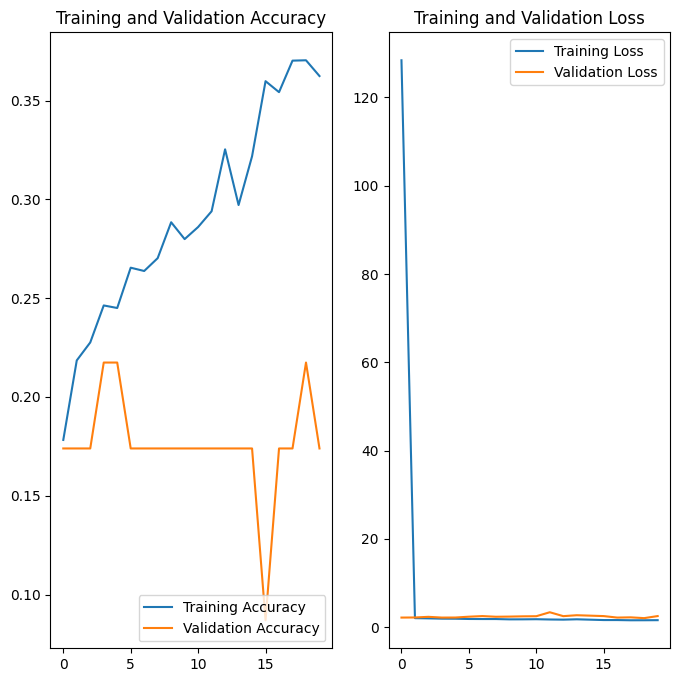

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
true_labels = np.concatenate([y for x, y in val_ds], axis=0)  # Extract true labels from validation dataset
val_predictions = model2.predict(val_ds)  # Predict on the validation dataset
predicted_classes = np.argmax(val_predictions, axis=1)
predicted_classes

# 2. Create confusion matrix
report = classification_report(true_labels, predicted_classes)  # Replace with your class names
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.19      1.00      0.32         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6

    accuracy                           0.17        23
   macro avg       0.03      0.14      0.05        23
weighted avg       0.03      0.17      0.06        23



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- Validation loss has decreased and looks relatively closer to the training loss, but accuracy of the model with validation dataset has dropped.
- Model still shows overfitting as the performance/accuracy decreases significantly when model works with test data although it shows high accuracy with training data.
- The validation accuracy curve has less peaks and drops.
- Model imbalace still seems to present

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.



In [27]:
path_to_dataset = r"/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//"
class_names = class_names = os.listdir(path_to_dataset)

In [28]:
# Check the proportion of total training data available in each class.
class_counts = {}
for class_name in class_names:
     class_path = os.path.join(path_to_dataset, class_name)
     if os.path.isdir(class_path):
          # Count the number of image files in the folder
            num_images = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])

            class_counts[class_name] = num_images


# Print the results
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of images: {count}")
    print(f"\tPercentage of samples: ", count/sum(class_counts.values()))


Class: actinic keratosis, Number of images: 114
	Percentage of samples:  0.05091558731576597
Class: basal cell carcinoma, Number of images: 376
	Percentage of samples:  0.16793211255024565
Class: dermatofibroma, Number of images: 95
	Percentage of samples:  0.04242965609647164
Class: melanoma, Number of images: 438
	Percentage of samples:  0.19562304600267977
Class: nevus, Number of images: 357
	Percentage of samples:  0.15944618133095131
Class: pigmented benign keratosis, Number of images: 462
	Percentage of samples:  0.20634211701652524
Class: seborrheic keratosis, Number of images: 77
	Percentage of samples:  0.03439035283608754
Class: squamous cell carcinoma, Number of images: 181
	Percentage of samples:  0.08083966056275123
Class: vascular lesion, Number of images: 139
	Percentage of samples:  0.062081286288521664


### Observations:

- Class seborrheic keratosis has only 77 samples which is only 3% of the total samples.
- Class pigmented benign keratosis has the majority samples followed by melanoma and basal cell carcinoma


#### Rectify the class imbalance
#### **Context:** We can add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E820018FCD0>: 100%|██████████| 500/500 [00:18<00:00, 27.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8200343310>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E82002932E0>: 100%|██████████| 500/500 [00:19<00:00, 26.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E81E95235E0>: 100%|██████████| 500/500 [01:33<00:00,  5.35 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E8200313580>: 100%|██████████| 500/500 [01:15<00:00,  6.66 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8200271990>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E82003FB3A0>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E821843F550>: 100%|██████████| 500/500 [00:21<00:00, 23.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8200423640>: 100%|██████████| 500/500 [00:27<00:00, 18.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_82d1af66-b94b-4f05-ba83-1ea12e371e76.jpg',
 '/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_e2c5f0c4-cdb8-4266-b837-c6ee175d1022.jpg',
 '/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_eb5e523b-d819-48bf-bb15-38044f27e184.jpg',
 '/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_dc809d76-50dd-43fe-9d05-d6fa39d0afca.jpg',
 '/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Skin cancer ISIC /Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030143.jpg_039e7644-52b6-4d6a-8c53-499bbc576053.jpg',
 '/content/gdrive/MyDrive/DataSet_Melanoma_Detection/Sk

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
# Creating a new dataframe
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [35]:
df['Label'].value_counts()

,count
Label,
actinic keratosis,1000
basal cell carcinoma,1000
dermatofibroma,1000
melanoma,1000
nevus,1000
pigmented benign keratosis,1000
seborrheic keratosis,1000
squamous cell carcinoma,1000
vascular lesion,1000


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


####  Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create a new model for the augmented data

In [39]:
## your code goes here
# Normalize pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)

#Normalizing training and validation data
# Apply normalization to training and validation datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimize dataset performance by prefetching data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model3 = keras.Sequential([
   # Input layer
    layers.InputLayer(shape=(180,180,3)),

   # # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Introducing an additional convolution layer
    # # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # # Flatten layer to convert 3D data to 1D
    layers.Flatten(),

    # # Fully connected (dense) layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Introducing another regularization to prevent overfitting

    # # Output layer
    layers.Dense(9, activation='softmax')
    ])


#### Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])

In [41]:
# Display the model summary
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [42]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 102s 103ms/step - accuracy: 0.1801 - loss: 2.2258 - val_accuracy: 0.4063 - val_loss: 1.5371
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.3831 - loss: 1.5831 - val_accuracy: 0.4673 - val_loss: 1.3919
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.4536 - loss: 1.4238 - val_accuracy: 0.5607 - val_loss: 1.2224
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5284 - loss: 1.2693 - val_accuracy: 0.5874 - val_loss: 1.0782
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5706 - loss: 1.1346 - val_accuracy: 0.6551 - val_loss: 0.9641
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6311 - loss: 0.9942 - val_accuracy: 0.6520 - val_loss: 0.9938
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6716 - loss: 0.8845 - val_accuracy: 0.7267 - val_loss: 0.7583
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7288 - loss: 0.7483 - v

#### Visualize the model results

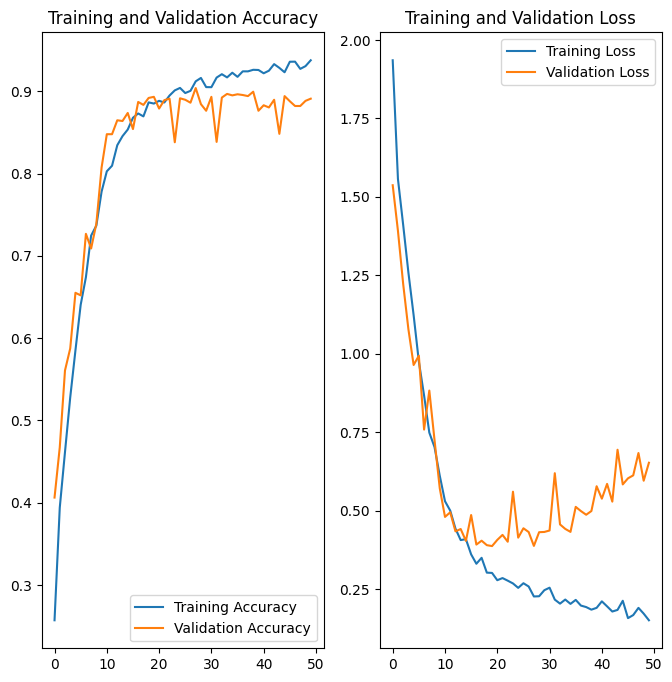

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
# Create Classification report
true_labels = np.concatenate([y for x, y in val_ds], axis=0)  # Extract true labels from validation dataset
val_predictions = model3.predict(val_ds)  # Predict on the validation dataset
predicted_classes = np.argmax(val_predictions, axis=1)

# 2. Create confusion matrix
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.76      0.86      0.81       207
      basal cell carcinoma       0.95      0.91      0.93       290
            dermatofibroma       0.97      0.98      0.98       225
                  melanoma       0.87      0.77      0.82       288
                     nevus       0.81      0.78      0.79       253
pigmented benign keratosis       0.91      0.93      0.92       299
      seborrheic keratosis       0.82      0.86      0.84       210
   squamous cell carcinoma       0.92      0.94      0.93       236
           vascular lesion       1.00      1.00      1.00       239

                  accuracy                           0.89      2247
                 macro avg       0.89      0.89      0.89      2247
              weighted avg       0.89      0.89      0.89      2247



#### Observations:

- The validation accuracy has improved to 85% now.
- Till Epoch 20, the loss is similar for both training and validation dataset

We can conclude that the overfitting issue has been handled.



## Predictions on Test Data

In [45]:
# Load and preprocess the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 118 files belonging to 9 classes.


In [46]:
# Normalize the test dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [47]:
test_class_names = class_names = class_names = os.listdir(data_dir_test)
print(test_class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'nevus', 'seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'pigmented benign keratosis', 'vascular lesion']


In [48]:
# Make predictions
predictions = model3.predict(test_ds).argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [49]:
# Map indices to class names
predicted_class_names = [test_class_names[i] for i in predictions]

In [50]:
# Display predictions
for i, pred in enumerate(predicted_class_names[:10]):  # Show the first 10 predictions
    print(f"Prediction {i + 1}: {pred}")

Prediction 1: seborrheic keratosis
Prediction 2: seborrheic keratosis
Prediction 3: seborrheic keratosis
Prediction 4: seborrheic keratosis
Prediction 5: seborrheic keratosis
Prediction 6: melanoma
Prediction 7: melanoma
Prediction 8: seborrheic keratosis
Prediction 9: seborrheic keratosis
Prediction 10: seborrheic keratosis
